# **Nushrat Tarmin Meem (1907083)**

### *1) NCBI Dataset: RefSeq Non-redundant Protein Database (RefSeq WP Acessions) Bacterial Protein Families (Enterobacteriaceae, Escherichia etc.)*

In [35]:
import os
directory = "/kaggle/input/ncbi-data/ncbi_dataset/ncbi_dataset/data"
files = os.listdir(directory)
print(files)

['GCF_963681135.1', 'assembly_data_report.jsonl', 'data_summary.tsv', 'dataset_catalog.json']


### *2) Installing and Importing Required Libraries:*

In [36]:
!pip install biopython --quiet

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
from collections import Counter
from Bio import SeqIO
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, GRU, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2

### *3) Loading Sequences and Labels:*

In [37]:
from Bio import SeqIO
from collections import Counter

# === Loading FASTA sequences ===
fasta_file = "/kaggle/input/ncbi-data/ncbi_dataset/ncbi_dataset/data/GCF_963681135.1/protein.faa"
sequences = list(SeqIO.parse(fasta_file, "fasta"))
print(f"✅Total Sequences Parsed from FASTA: {len(sequences)}")

# === Extracting labels ===
def extract_label(description):
    if "[" in description and "]" in description:
        return description.split("[")[-1].split("]")[0]
    return "Unknown"

labels = [extract_label(rec.description) for rec in sequences]
label_counts = Counter(labels)
top_labels = [label for label, _ in label_counts.most_common(3)]

print("✅Top 3 Labels:")
for i, label in enumerate(top_labels, 1):
    print(f"{i}. {label} ({label_counts[label]} sequences)")

# === Filtering by top labels ===
filtered_data = [(rec, label) for rec, label in zip(sequences, labels) if label in top_labels]
print(f"✅Total Sequences After Filtering for Top 3 Labels: {len(filtered_data)}")

# === Unpacking filtered data ===
filtered_seqs, filtered_labels = zip(*filtered_data)

✅Total Sequences Parsed from FASTA: 4943
✅Top 3 Labels:
1. Enterobacteriaceae (2338 sequences)
2. Escherichia coli (1294 sequences)
3. Escherichia (635 sequences)
✅Total Sequences After Filtering for Top 3 Labels: 4267


### *4) Tokenizing Sequences:*

In [38]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_index = {aa: i + 1 for i, aa in enumerate(amino_acids)}
vocab_size = len(aa_to_index) + 1

def tokenize_sequence(seq):
    return [aa_to_index.get(aa, 0) for aa in seq if aa in aa_to_index]

tokenized_seqs = [tokenize_sequence(str(rec.seq)) for rec in filtered_seqs]
tokenized_seqs = [seq for seq in tokenized_seqs if len(seq) >= 50]
filtered_labels = [lbl for seq, lbl in zip(tokenized_seqs, filtered_labels) if len(seq) >= 50]

print(f"✅Amino Acid Vocabulary Size (Excluding Padding): {len(aa_to_index)}")
print(f"✅Total Vocabulary Size (Including Padding Token 0): {vocab_size}")
print("✅Example Tokenized Sequence (First One First 50 Tokens):")
print(tokenized_seqs[0][:50])  
print(f"✅Sequences with ≥50 Amino Acids: {len(tokenized_seqs)}")
sequence_lengths = [len(seq) for seq in tokenized_seqs]
print(f"✅Average Sequence Length: {sum(sequence_lengths) / len(sequence_lengths):.2f}")
print(f"✅Max Sequence Length: {max(sequence_lengths)}")

✅Amino Acid Vocabulary Size (Excluding Padding): 20
✅Total Vocabulary Size (Including Padding Token 0): 21
✅Example Tokenized Sequence (First One First 50 Tokens):
[11, 1, 12, 10, 16, 6, 20, 12, 5, 1, 20, 10, 3, 4, 14, 17, 9, 15, 11, 8, 15, 15, 1, 8, 10, 9, 1, 18, 1, 8, 13, 6, 20, 14, 18, 13, 5, 6, 6, 15, 4, 11, 13, 11, 13, 20, 6, 19, 6, 17]
✅Sequences with ≥50 Amino Acids: 4206
✅Average Sequence Length: 336.50
✅Max Sequence Length: 3515


### *5) Padding Sequences and Encoding Labels:*

In [39]:
maxlen = 500
X = pad_sequences(tokenized_seqs, maxlen=maxlen, padding='post', truncating='post')

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(filtered_labels)
Y = to_categorical(Y)

print(f"✅Input shape (X): {X.shape}  → (samples, padded_sequence_length)")
print(f"✅Output shape (Y): {Y.shape}  → (samples, number_of_classes)")

print("✅Encoded Label Classes:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

print("✅Example Padded Sequence (first 20 tokens):")
print(X[0][:20])

print("✅Corresponding One-Hot Label Vector:")
print(Y[0])

import numpy as np
class_counts = np.sum(Y, axis=0)
print("📊Class Distribution in One-Hot Format:")
for idx, (name, count) in enumerate(zip(label_encoder.classes_, class_counts)):
    print(f"{name}: {int(count)} samples")

✅Input shape (X): (4206, 500)  → (samples, padded_sequence_length)
✅Output shape (Y): (4206, 3)  → (samples, number_of_classes)
✅Encoded Label Classes:
0: Enterobacteriaceae
1: Escherichia
2: Escherichia coli
✅Example Padded Sequence (first 20 tokens):
[11  1 12 10 16  6 20 12  5  1 20 10  3  4 14 17  9 15 11  8]
✅Corresponding One-Hot Label Vector:
[1. 0. 0.]
📊Class Distribution in One-Hot Format:
Enterobacteriaceae: 2332 samples
Escherichia: 634 samples
Escherichia coli: 1240 samples


### *6) Bar Chart of Class Distribution (One-Hot Encoded Labels):*

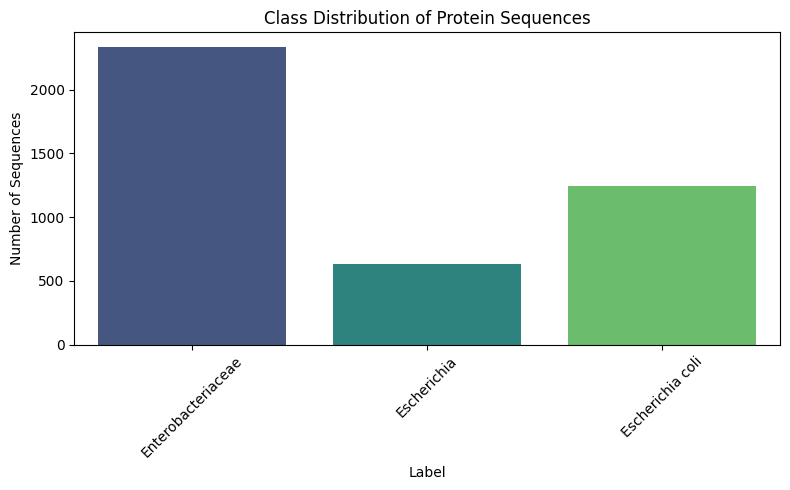

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
class_counts = np.sum(Y, axis=0)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=class_counts, palette='viridis')
plt.title("Class Distribution of Protein Sequences")
plt.xlabel("Label")
plt.ylabel("Number of Sequences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### *7) Train-Test Splitting:*

In [41]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("✅Dataset Split Summary:")
print(f"🧠Training set:     {X_train.shape[0]} samples")
print(f"🧪Validation set:   {X_val.shape[0]} samples")
print(f"🔬Test set:         {X_test.shape[0]} samples")

✅Dataset Split Summary:
🧠Training set:     2944 samples
🧪Validation set:   631 samples
🔬Test set:         631 samples


### *8) Callback for Weight Saving:*

In [42]:
class WeightTracker(Callback):
    def __init__(self, save_dir="/kaggle/working/weights"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        for i, layer in enumerate(self.model.layers):
            weights = layer.get_weights()
            for j, w in enumerate(weights):
                np.save(os.path.join(self.save_dir, f"epoch_{epoch}_layer_{i+1}_weight_{j+1}.npy"), w)

### *9) Building the Model:*

In [43]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

num_classes = Y.shape[1]

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### *10) Training the Model:*

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
weight_tracker = WeightTracker()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=8,
    callbacks=[early_stop, weight_tracker]
)

Epoch 1/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.3765 - loss: 1.8663 - val_accuracy: 0.5705 - val_loss: 1.1675
Epoch 2/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4749 - loss: 1.3738 - val_accuracy: 0.5468 - val_loss: 1.1508
Epoch 3/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5138 - loss: 1.2336 - val_accuracy: 0.5753 - val_loss: 1.1397
Epoch 4/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5174 - loss: 1.1805 - val_accuracy: 0.5721 - val_loss: 1.0863
Epoch 5/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5443 - loss: 1.1215 - val_accuracy: 0.5626 - val_loss: 1.0742
Epoch 6/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5449 - loss: 1.0843 - val_accuracy: 0.5721 - val_loss: 1.0662
Epoch 7/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5413 - loss: 1.0622 - val_accuracy: 0.5753 - val_loss: 1.0566
Epoch 8/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5285 - loss: 1.0715 - 

### *11) Model Structure Summary:*

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (8, 500, 64)                │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (8, 500, 128)               │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (8, 500, 128)               │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (8, 500, 128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (8, 128)                    │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (8, 128)                    │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (8, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (8, 3)                      │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,995 (1.35 MB)

 Trainable params: 117,827 (460.26 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 235,656 (920.54 KB)

### *12) Generating GIFS:*

In [46]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio 
import numpy as np
import os

# === Paths ===
weights_dir = "/kaggle/working/weights"
gif_output_dir = "/kaggle/working/weight_gifs"
os.makedirs(gif_output_dir, exist_ok=True)

# === Parsing .npy Files ===
epoch_files = [f for f in os.listdir(weights_dir) if f.endswith(".npy")]
layer_epoch_map = {}

# === Grouping by (layer, epoch), collecting all weight indices for each ===
for f in epoch_files:
    parts = f.split('_')
    epoch = int(parts[1])
    layer = int(parts[3])
    weight_idx = int(parts[5].split('.')[0])
    key = (layer, epoch)
    if key not in layer_epoch_map:
        layer_epoch_map[key] = []
    layer_epoch_map[key].append((weight_idx, os.path.join(weights_dir, f)))

# === Generating GIFs per Layer ===
layers = sorted(set(layer for layer, _ in layer_epoch_map.keys()))

for layer in layers:
    layer_epochs = sorted(e for l, e in layer_epoch_map if l == layer)
    images = []

    for epoch in layer_epochs:
        weight_files = sorted(layer_epoch_map[(layer, epoch)], key=lambda x: x[0])  # sort by weight_idx
        all_weights = []

        for weight_idx, filepath in weight_files:
            weights = np.load(filepath)

            # === Ensuring 2D for visualization ===
            if weights.ndim == 1:
                weights = weights.reshape(1, -1)
            elif weights.ndim > 2:
                weights = weights[0]

            all_weights.append(weights)

        # === Stacking vertically (best for visualization) ===
        combined_weights = np.vstack(all_weights)

        # === Plotting ===
        fig, ax = plt.subplots(figsize=(6, 6))
        cax = ax.matshow(combined_weights, cmap='viridis')
        weight_indices_str = ','.join(str(wi) for wi, _ in weight_files)
        plt.title(f"Layer {layer} | Epoch {epoch} | Weights: [{weight_indices_str}]", fontsize=10)
        fig.colorbar(cax)
        plt.axis('off')

        # === Saving frame image ===
        img_path = f"/tmp/layer{layer}_epoch{epoch}.png"
        plt.savefig(img_path)
        plt.close(fig)
        images.append(imageio.imread(img_path))

    # === Saving GIF ===
    gif_path = os.path.join(gif_output_dir, f"layer{layer}_weights.gif")
    imageio.mimsave(gif_path, images, fps=2)

print("✅GIF generation Complete!")

✅GIF generation Complete!


### *13) Displaying GIFS:*

In [47]:
from IPython.display import display
import ipywidgets as widgets

gif_paths = [
    "/kaggle/working/weight_gifs/layer1_weights.gif",
    "/kaggle/working/weight_gifs/layer2_weights.gif",
    "/kaggle/working/weight_gifs/layer3_weights.gif",
    "/kaggle/working/weight_gifs/layer5_weights.gif",
    "/kaggle/working/weight_gifs/layer6_weights.gif",
    "/kaggle/working/weight_gifs/layer8_weights.gif",
]

# === Loading the GIFs as widget.Image objects ===
imgs = [widgets.Image(value=open(path, "rb").read(), format='gif', width=450) for path in gif_paths]

# === Creating a 3-column, 2-row grid layout ===
grid = widgets.GridBox(
    children=imgs,
    layout=widgets.Layout(
        grid_template_columns="repeat(3, 1fr)",  # 3 columns
        grid_template_rows="repeat(2, auto)",   # 2 rows
        grid_gap="10px",
        justify_items="center"
    )
)

# === Displaying the grid ===
display(grid)

GridBox(children=(Image(value=b'GIF89aX\x02X\x02\x87\x00\x00\xfe\xfe\xfe"\x88\x8c)x\x8d2\xb5y/g\x8d\x1e\x98\x8…

### *14) Accuracy and Loss Plotting:*

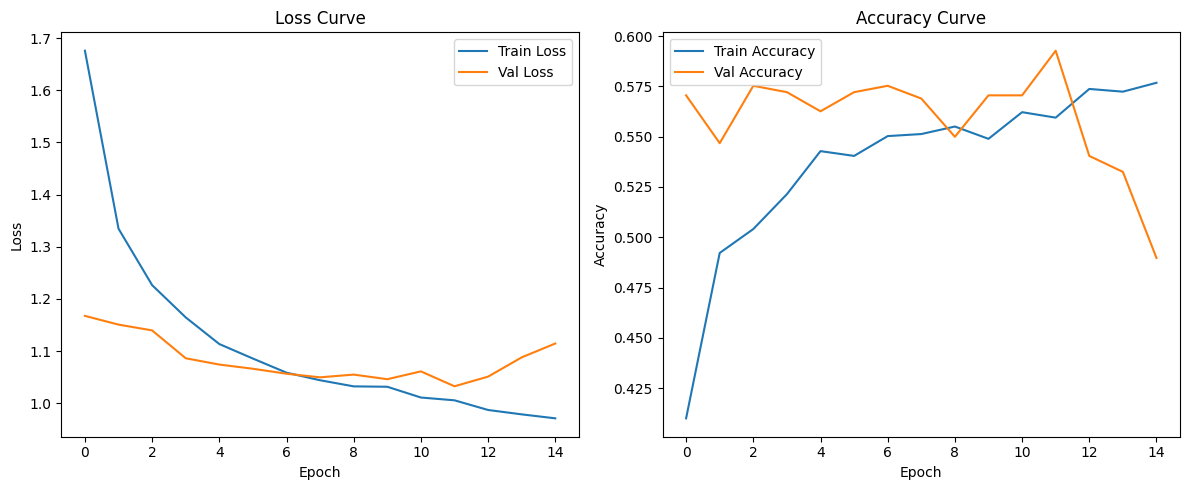

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### *15) Confusion Matrix Plotting:*

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


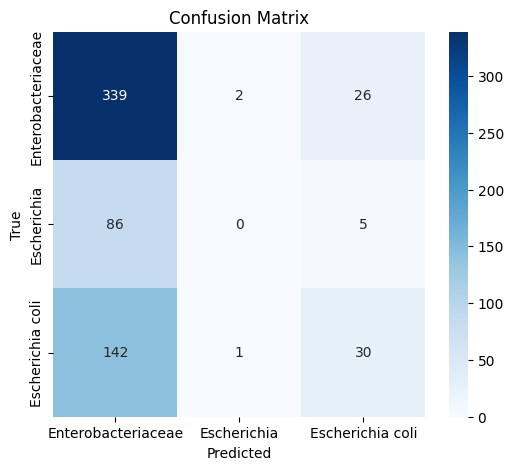

In [49]:
Y_test_pred_probs = model.predict(X_test)
Y_test_pred = Y_test_pred_probs.argmax(axis=-1).flatten()
Y_test_true = Y_test.argmax(axis=-1).flatten()

cm = confusion_matrix(Y_test_true, Y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### *16) Calculation of Evaluation Metrics: Precision, Recall, F1-Score and Accuracy:*

In [50]:
Y_test_pred_probs = model.predict(X_test)
Y_test_pred = Y_test_pred_probs.argmax(axis=1)
Y_test_true = Y_test.argmax(axis=1)

from sklearn.metrics import classification_report, accuracy_score

report = classification_report(Y_test_true, Y_test_pred, target_names=label_encoder.classes_, digits=4)
print("✅Classification Report:\n", report)

accuracy = accuracy_score(Y_test_true, Y_test_pred)
print(f"✅Test Accuracy: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
✅Classification Report:
                     precision    recall  f1-score   support

Enterobacteriaceae     0.5979    0.9237    0.7259       367
       Escherichia     0.0000    0.0000    0.0000        91
  Escherichia coli     0.4918    0.1734    0.2564       173

          accuracy                         0.5848       631
         macro avg     0.3632    0.3657    0.3274       631
      weighted avg     0.4826    0.5848    0.4925       631

✅Test Accuracy: 0.5848


### *17) Zipping Folders to Download from Kaggle:*

In [51]:
!zip -r /kaggle/working/weights.zip /kaggle/working/weights > /dev/null
!zip -r /kaggle/working/weight_gifs.zip /kaggle/working/weight_gifs > /dev/null
print(f"✅Ready to be Downloaded!")

✅Ready to be Downloaded!
